In [1]:
import os
import sys
import pickle
import random
from pathlib import Path
from IPython.display import display


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import catboost as cab


sys.path.append("../../../")
from kagglib.tabular import (
    AbstractBaseBlock,
    IdentityBlock,
    WrapperBlock,
    LabelEncodingBlock,
    CountEncodingBlock,
    AggBlock,
    run_blocks,
)


pd.set_option('display.max_columns', 300)

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
class Config:
    exp = "exp053"

    input_path = Path("../input")
    output_path = Path("../output")

    exp_path = output_path / exp
    exp_model_path = exp_path / "model"
    exp_pred_path = exp_path / "pred"

    for _path in [exp_path, exp_model_path, exp_pred_path]:
        if not _path.exists():
            _path.mkdir(parents=True)

    seed = 42
    n_splits = 5
    
    model_params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "learning_rate": 0.02,
        "random_state": seed,
        'bagging_fraction': 0.9868588999565879,
        'bagging_freq': 7,
        'lambda_l1': 5.938798518618477,
        'lambda_l2': 5.026940843647876e-07,
    }

    train_params = {
        "num_boost_round": 999999,
    }

cfg = Config

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
anime_df = pd.read_csv(cfg.input_path / "anime.csv")
train_df = pd.read_csv(cfg.input_path / "train.csv")
test_df = pd.read_csv(cfg.input_path / "test.csv")
sample_submission_df = pd.read_csv(cfg.input_path / "sample_submission.csv")

In [7]:
dup_user_id = set(train_df["user_id"]) & set(test_df["user_id"])
dup_anime_id = set(train_df["anime_id"]) & set(test_df["anime_id"])
train_df["is_seen"] = 0
test_df["is_seen"] = 0

# seen
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
seen_train_idx = (train_df["user_id"].isin(dup_user_id)) & (train_df["anime_id"].isin(dup_anime_id))
seen_test_idx = (test_df["user_id"].isin(dup_user_id)) & (test_df["anime_id"].isin(dup_anime_id))
train_df.loc[seen_train_idx, "is_seen"] = 1
test_df.loc[seen_test_idx, "is_seen"] = 1

seen_train_df = train_df[train_df["is_seen"] == 1].copy().reset_index(drop=True)
seen_train_df["seen_fold"] = -1
for i_fold, (_, valid_idx) in enumerate(skf.split(seen_train_df, seen_train_df["score"])):
    seen_train_df.loc[valid_idx, "seen_fold"] = i_fold


# unseen
sgkf = StratifiedGroupKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
unseen_train_idx = (~train_df["user_id"].isin(dup_user_id)) | (~train_df["anime_id"].isin(dup_anime_id))
unseen_test_idx = (~test_df["user_id"].isin(dup_user_id)) | (~test_df["anime_id"].isin(dup_anime_id))
train_df.loc[unseen_train_idx, "is_seen"] = 0
test_df.loc[unseen_test_idx, "is_seen"] = 0

train_df["unseen_fold"] = -1
for i_fold, (_, valid_idx) in enumerate(sgkf.split(train_df, train_df["score"], train_df["user_id"])):
    train_df.loc[valid_idx, "unseen_fold"] = i_fold



train_df = pd.merge(train_df, seen_train_df[["user_id", "anime_id", "seen_fold"]], on=["user_id", "anime_id"], how="left")

# Preprocess

In [8]:
# 文字列で表された月を数値に変換
month_dict = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

In [9]:
def convert_to_minutes(time_str):
    time_str = time_str.lower()
    
    if 'unknown' in time_str:
        return np.nan
    elif 'hr.' in time_str and 'min.' in time_str:
        time_parts = time_str.split(' hr. ')
        hours = int(time_parts[0])
        minutes = int(time_parts[1].replace(' min.', '').replace(' per ep.', ''))
        total_time = (hours * 60) + minutes
    elif 'hr.' in time_str:
        hours = int(time_str.replace(' hr.', '').replace(' per ep.', ''))
        total_time = hours * 60
    elif 'min.' in time_str:
        minutes = int(time_str.replace(' min.', '').replace(' per ep.', ''))
        total_time = minutes

    return total_time

def convert_to_rating_code(rating_str):
    rating_str = rating_str.lower()
    ratings_dict = {
        'g - all ages': 0,
        'pg - children': 1,
        'pg-13 - teens 13 or older': 2,
        'r - 17+ (violence & profanity)': 3,
        'r+ - mild nudity': 4,
        'rx - hentai': 5,
        'unknown': np.nan
    }
    
    return ratings_dict.get(rating_str, np.nan)

In [10]:
def preprocess_anime_df(input_df):
    output_df = anime_df.copy()

    # 日付
    output_df[["start_date", "end_date"]] = output_df["aired"].str.split(" to ", expand=True)
    # start_dateを分割
    output_df[['start_month', 'start_day', 'start_year']] = output_df['start_date'].str.split(' ', expand=True)
    output_df.loc[~output_df["start_day"].isnull(), "start_day"] = output_df.loc[~output_df["start_day"].isnull(), "start_day"].str.replace(",", "")
    output_df['start_month'] = output_df['start_month'].map(month_dict)
    # end_dateを分割
    output_df[['end_month', 'end_day', 'end_year']] = output_df['end_date'].str.split(' ', expand=True)
    output_df.loc[~output_df["end_day"].isnull(), "end_day"] = output_df.loc[~output_df["end_day"].isnull(), "end_day"].str.replace(",", "")
    output_df['end_month'] = output_df['end_month'].map(month_dict)

    output_df = output_df.fillna(-1)

    # start_yearとstart_dayを整数型に変換
    output_df[['start_year', 'start_month', 'start_day']] = output_df[['start_year', 'start_month', 'start_day']].astype(int)
    # end_yearとend_dayを整数型に変換
    output_df[['end_year', 'end_month', 'end_day']] = output_df[['end_year', 'end_month', 'end_day']].astype(int)

    output_df["episodes"] = output_df["episodes"].replace("Unknown", -1).astype(float)

    output_df["duration"] = output_df["duration"].apply(convert_to_minutes).astype(float)
    # output_df["rating"] = output_df["rating"].apply(convert_to_rating_code).astype(float)

    return output_df

In [11]:
anime_df = preprocess_anime_df(anime_df)

# Feature Engineering

In [12]:
from tqdm.notebook import tqdm
from itertools import combinations
from IPython.display import display
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import DisjointSet
import Levenshtein

def get_original_work_name(df, threshold=0.3):

    _feature = df.japanese_name.tolist()
    _n = df.shape[0]

    _disjoint_set = DisjointSet(list(range(_n)))
    for i, j in tqdm(combinations(range(_n), 2)):
        if _feature[i] is np.nan or _feature[j] is np.nan:
            lv_dist, jw_dist = 0.5, 0.5
        else:
            lv_dist = 1 - Levenshtein.ratio(_feature[i], _feature[j])
            jw_dist = 1 - Levenshtein.jaro_winkler(_feature[i], _feature[j])
        _d = (lv_dist + jw_dist) / 2

        if _d < threshold:
            _disjoint_set.merge(i, j)

    _labels = [None] * _n
    for subset in _disjoint_set.subsets():
        label = _feature[list(subset)[0]]
        for element in subset:
            _labels[element] = label
    df["original_work_name"] = _labels

    return df


anime_df = get_original_work_name(anime_df)
print(f"raw - japanese_name nunique: {anime_df.japanese_name.nunique()}")
print(f"processed - japanese_name nunique: {anime_df.original_work_name.nunique()}")
display(anime_df.head(4))

0it [00:00, ?it/s]

raw - japanese_name nunique: 1931
processed - japanese_name nunique: 1389


,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch,start_date,end_date,start_month,start_day,start_year,end_month,end_day,end_year,original_work_name
0,000ba7f7e34e107e7544,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",宇宙兄弟,TV,99.0,"Apr 1, 2012 to Mar 22, 2014","Aniplex, Dentsu, YTV, Trinity Sound",Sentai Filmworks,A-1 Pictures,Manga,24.0,PG-13 - Teens 13 or older,150428,16552,37234,13009,6948,76685,"Apr 1, 2012","Mar 22, 2014",4,1,2012,3,22,2014,宇宙兄弟
1,00427279d72064e7fb69,"Adventure, Slice of Life, Mystery, Historical,...",蟲師,TV,26.0,"Oct 23, 2005 to Jun 19, 2006","Avex Entertainment, Marvelous, SKY Perfect Wel...",Funimation,Artland,Manga,25.0,PG-13 - Teens 13 or older,620736,55482,235371,42786,20017,267080,"Oct 23, 2005","Jun 19, 2006",10,23,2005,6,19,2006,蟲師
2,00444b67aaabdf740a68,"Adventure, Slice of Life, Mystery, Historical,...",蟲師 続章,TV,10.0,"Apr 5, 2014 to Jun 21, 2014","Aniplex, Kodansha, Delfi Sound",Aniplex of America,Artland,Manga,24.0,PG-13 - Teens 13 or older,226522,12585,113559,6095,2606,91677,"Apr 5, 2014","Jun 21, 2014",4,5,2014,6,21,2014,蟲師
3,00839a3507ab168abe75,"Comedy, Ecchi, Fantasy, School",星刻の竜騎士,TV,12.0,"Apr 5, 2014 to Jun 21, 2014","Media Factory, AT-X, Sony Music Communications...",Funimation,C-Station,Light novel,24.0,R+ - Mild Nudity,170220,8723,118202,3753,8034,31508,"Apr 5, 2014","Jun 21, 2014",4,5,2014,6,21,2014,星刻の竜騎士


## 複数ラベル特徴量

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

n_components = 64

multilabel_cols = ["genres", "producers", "licensors", "studios"]
multilabel_dfs = []
for c in multilabel_cols:
    list_srs = anime_df[c].map(lambda x: x.split(", ")).tolist()
    len_srs = anime_df[c].map(lambda x: len(x.split(", ")))
    mlb = MultiLabelBinarizer()
    ohe_srs = mlb.fit_transform(list_srs)
    if c == "genres" or c == "licensors":
        col_df = pd.DataFrame(ohe_srs, columns=[f"ohe_{c}_{name}" for name in mlb.classes_])
        col_df[f"n_{c}"] = len_srs
    else:
        continue
        # # ユニーク数が多いので、SVDで次元圧縮する
        # svd = TruncatedSVD(n_components=n_components, random_state=cfg.seed)
        # svd_arr = svd.fit_transform(ohe_srs)
        # col_df = pd.DataFrame(
        #     svd_arr,
        #     columns=[f"svd_{c}_{ix}" for ix in range(n_components)]
        # )
        # col_df[f"len_{c}"] = len_srs
    multilabel_dfs.append(col_df)

multilabel_df = pd.concat(multilabel_dfs, axis=1)
multilabel_feat_cols = multilabel_df.columns.tolist()

In [14]:
anime_df = pd.concat([anime_df, multilabel_df], axis=1)

## Implicit feedback embeddings (all)

In [15]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, auc_score

In [18]:
train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

dataset = Dataset()

train_test_user = sorted(train_test_df["user_id"].unique())
train_test_item = sorted(train_test_df["anime_id"].unique())
dataset.fit(
    users=train_test_user, 
    items=train_test_item,
    )

num_users, num_topics = dataset.interactions_shape()
print(f'Number of users: {num_users}, Number of topics: {num_topics}.')

id_cols = ["user_id", "anime_id"]

(interactions, weights) = dataset.build_interactions(train_test_df[id_cols].to_numpy())

model = LightFM(
    loss='warp', 
    no_components=128, 
    learning_rate=0.01,
    random_state=cfg.seed,
    )
model.fit(
    interactions=interactions,
    epochs=40,
    verbose=1,
    )

Number of users: 1998, Number of topics: 1956.


Epoch: 100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


In [19]:
implicit_user_cols = [f"implicit_user_{ix}" for ix in range(128)]
implicit_user_df = pd.DataFrame(
    model.user_embeddings,
    columns=implicit_user_cols
)
implicit_user_df["user_id"] = train_test_user

implicit_item_cols = [f"implicit_item_{ix}" for ix in range(128)]
implicit_item_df = pd.DataFrame(
    model.item_embeddings,
    columns=implicit_item_cols
)
implicit_item_df["anime_id"] = train_test_item

train_test_df = pd.merge(train_test_df, implicit_user_df, on="user_id", how="left")
train_test_df = pd.merge(train_test_df, implicit_item_df, on="anime_id", how="left")

_train_df = train_test_df[~train_test_df["score"].isnull()].reset_index(drop=True)
_test_df = train_test_df[train_test_df["score"].isnull()].reset_index(drop=True)

_train_df = _train_df[id_cols + implicit_user_cols + implicit_item_cols]
_test_df = _test_df[id_cols + implicit_user_cols + implicit_item_cols]

train_df = pd.merge(train_df, _train_df, on=id_cols, how="left")
test_df = pd.merge(test_df, _test_df, on=id_cols, how="left")

## ALS

In [20]:
import implicit
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# ユーザーとアイテムの ID をカテゴリ型に変換します。
train_test_df['user_id'] = train_test_df['user_id'].astype("category")
train_test_df['anime_id'] = train_test_df['anime_id'].astype("category")

user_item = coo_matrix((np.ones(train_test_df.shape[0]),
                        (train_test_df['anime_id'].cat.codes.copy(),
                         train_test_df['user_id'].cat.codes.copy())))
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    random_state=cfg.seed,
    )

model.fit(user_item)

user_factors = model.user_factors.to_numpy()
item_factors = model.item_factors.to_numpy()

als_implicit_user_cols = [f"als_implicit_user_{ix}" for ix in range(128)]
implicit_user_df = pd.DataFrame(
    user_factors,
    columns=als_implicit_user_cols
)

als_implicit_item_cols = [f"als_implicit_item_{ix}" for ix in range(128)]
implicit_item_df = pd.DataFrame(
    item_factors,
    columns=als_implicit_item_cols
)

train_test_df = pd.merge(train_test_df, implicit_user_df, left_on="user_id", right_index=True, how="left")
train_test_df = pd.merge(train_test_df, implicit_item_df, left_on="anime_id", right_index=True, how="left")

_train_df = train_test_df[~train_test_df["score"].isnull()].reset_index(drop=True)
_test_df = train_test_df[train_test_df["score"].isnull()].reset_index(drop=True)    

id_cols = ["user_id", "anime_id"]
_train_df = _train_df[id_cols + als_implicit_user_cols + als_implicit_item_cols]
_test_df = _test_df[id_cols + als_implicit_user_cols + als_implicit_item_cols]

train_df = pd.merge(train_df, _train_df, on=id_cols, how="left")
test_df = pd.merge(test_df, _test_df, on=id_cols, how="left")

/home/shugo/kaggle/venv_desktop/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0068857669830322266 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
# umap
# import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

_train_df = train_df.groupby("user_id")[implicit_user_cols].mean().reset_index()
kmeans = KMeans(n_clusters=5, random_state=cfg.seed)
kmeans_result = kmeans.fit_transform(_train_df[implicit_user_cols])
_train_df["kmeans_user"] = kmeans.labels_
train_df = pd.merge(train_df, _train_df[["user_id", "kmeans_user"]], on="user_id", how="left")
test_df = pd.merge(test_df, _train_df[["user_id", "kmeans_user"]], on="user_id", how="left")

_train_df = train_df.groupby("anime_id")[implicit_item_cols].mean().reset_index()
kmeans = KMeans(n_clusters=10, random_state=cfg.seed)
kmeans_result = kmeans.fit_transform(_train_df[implicit_item_cols])
_train_df["kmeans_item"] = kmeans.labels_
train_df = pd.merge(train_df, _train_df[["anime_id", "kmeans_item"]], on="anime_id", how="left")
test_df = pd.merge(test_df, _train_df[["anime_id", "kmeans_item"]], on="anime_id", how="left")

/home/shugo/kaggle/venv_desktop/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/shugo/kaggle/venv_desktop/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Node2Vec

In [25]:
# import networkx as nx
# from node2vec import Node2Vec

# train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
# user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_test_df.groupby('user_id')['anime_id']}

# # データフレームからグラフを生成します
# G = nx.from_pandas_edgelist(train_test_df, 'user_id', 'anime_id')

# # Node2Vecモデルの初期化
# node2vec = Node2Vec(
#     G, 
#     dimensions=64,
#     walk_length=30,
#     num_walks=200,
#     workers=os.cpu_count(),
#     seed=cfg.seed,
#     )

# # モデルの訓練
# model = node2vec.fit(
#     window=10,
#     min_count=1,
#     )

In [26]:
node2vec_user_cols = [f"user_factor_{i}" for i in range(64)]
node2vec_anime_cols = [f"item_factor_{i}" for i in range(64)]

In [27]:
# user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}
# item_factors = {anime_id: model.wv[anime_id] for anime_id in anime_df["anime_id"].unique() if anime_id in model.wv}

# # データフレームを作成
# user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})
# item_factors_df = pd.DataFrame(item_factors).T.reset_index().rename(columns={"index": "anime_id"})

# # データフレームのカラム名をリネーム
# user_factors_df.columns = ["user_id"] + node2vec_user_cols
# item_factors_df.columns = ["anime_id"] + node2vec_anime_cols

In [28]:
# user_factors_df.to_csv(cfg.output_path / "user_factors.csv", index=False)
# item_factors_df.to_csv(cfg.output_path / "item_factors.csv", index=False)

user_factors_df = pd.read_csv(cfg.output_path / "user_factors.csv")
item_factors_df = pd.read_csv(cfg.output_path / "item_factors.csv")

In [29]:
train_df = pd.merge(train_df, user_factors_df, on="user_id", how="left")
train_df = pd.merge(train_df, item_factors_df, on="anime_id", how="left")

test_df = pd.merge(test_df, user_factors_df, on="user_id", how="left")
test_df = pd.merge(test_df, item_factors_df, on="anime_id", how="left")

## merge

In [30]:
train_df = pd.merge(train_df, anime_df, on="anime_id", how="left")
test_df = pd.merge(test_df, anime_df, on="anime_id", how="left")

## seen

In [31]:
from kagglib.tabular import TargetEncodingBlock

In [32]:
def seen_feature_engineering(train_df, test_df):

    # anime特徴量
    cat_cols = [
        "user_id",
        "anime_id",
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
        "start_year",
        "start_month",
        "start_day",
        "end_year",
        "end_month",
        "end_day",
        "kmeans_user",
        "kmeans_item",
    ]


    feat_cols = num_cols + multilabel_feat_cols + implicit_user_cols + implicit_item_cols + node2vec_user_cols + node2vec_anime_cols
    blocks = [
        IdentityBlock(use_cols=feat_cols),
        LabelEncodingBlock(cat_cols),
        # TargetEncodingBlock(cat_cols),
    ]

    train_anime_feat_df = run_blocks(train_df, blocks, y=train_df["score"], is_test=False)
    test_anime_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_anime_feat_df, test_anime_feat_df


def seen_fold_feature_engineering(train_df, valid_df, test_df):
    # user特徴量
    cat_cols = [
        "user_id",
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
    ]

    blocks = [
        *[CountEncodingBlock(c, normalize=True) for c in cat_cols],
        *[AggBlock(
            key=c,
            values=num_cols,
            funcs=["std", "sum", "mean", "max", "min"]) for c in cat_cols],
        *[AggBlock(
            key=c,
            values=multilabel_feat_cols,
            funcs=["std", "sum", "mean"]) for c in cat_cols],
        *[AggBlock(
            key="anime_id",
            values=["user_id"],
            funcs=["count"])],
        *[AggBlock(
            key="user_id",
            values=["anime_id"],
            funcs=["count"])],
        ]

    train_user_feat_df = run_blocks(train_df, blocks, is_test=False)
    valid_user_feat_df = run_blocks(valid_df, blocks, is_test=True)
    test_user_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_user_feat_df, valid_user_feat_df, test_user_feat_df

In [33]:
seen_train_feat_df, seen_test_feat_df = seen_feature_engineering(train_df, test_df)
display(seen_train_feat_df.head(1))
print(seen_train_feat_df.shape, seen_test_feat_df.shape)

,episodes@IdentityBlock,duration@IdentityBlock,members@IdentityBlock,watching@IdentityBlock,completed@IdentityBlock,on_hold@IdentityBlock,dropped@IdentityBlock,plan_to_watch@IdentityBlock,start_year@IdentityBlock,start_month@IdentityBlock,start_day@IdentityBlock,end_year@IdentityBlock,end_month@IdentityBlock,end_day@IdentityBlock,kmeans_user@IdentityBlock,kmeans_item@IdentityBlock,ohe_genres_Action@IdentityBlock,ohe_genres_Adventure@IdentityBlock,ohe_genres_Cars@IdentityBlock,ohe_genres_Comedy@IdentityBlock,ohe_genres_Dementia@IdentityBlock,ohe_genres_Demons@IdentityBlock,ohe_genres_Drama@IdentityBlock,ohe_genres_Ecchi@IdentityBlock,ohe_genres_Fantasy@IdentityBlock,ohe_genres_Game@IdentityBlock,ohe_genres_Harem@IdentityBlock,ohe_genres_Hentai@IdentityBlock,ohe_genres_Historical@IdentityBlock,ohe_genres_Horror@IdentityBlock,ohe_genres_Josei@IdentityBlock,ohe_genres_Kids@IdentityBlock,ohe_genres_Magic@IdentityBlock,ohe_genres_Martial Arts@IdentityBlock,ohe_genres_Mecha@IdentityBlock,ohe_genres_Military@IdentityBlock,ohe_genres_Music@IdentityBlock,ohe_genres_Mystery@IdentityBlock,ohe_genres_Parody@IdentityBlock,ohe_genres_Police@IdentityBlock,ohe_genres_Psychological@IdentityBlock,ohe_genres_Romance@IdentityBlock,ohe_genres_Samurai@IdentityBlock,ohe_genres_School@IdentityBlock,ohe_genres_Sci-Fi@IdentityBlock,ohe_genres_Seinen@IdentityBlock,ohe_genres_Shoujo@IdentityBlock,ohe_genres_Shoujo Ai@IdentityBlock,ohe_genres_Shounen@IdentityBlock,ohe_genres_Shounen Ai@IdentityBlock,ohe_genres_Slice of Life@IdentityBlock,ohe_genres_Space@IdentityBlock,ohe_genres_Sports@IdentityBlock,ohe_genres_Super Power@IdentityBlock,ohe_genres_Supernatural@IdentityBlock,ohe_genres_Thriller@IdentityBlock,ohe_genres_Vampire@IdentityBlock,ohe_genres_Yaoi@IdentityBlock,n_genres@IdentityBlock,ohe_licensors_4Kids Entertainment@IdentityBlock,ohe_licensors_ADV Films@IdentityBlock,ohe_licensors_Anchor Bay Films@IdentityBlock,ohe_licensors_AnimEigo@IdentityBlock,ohe_licensors_Aniplex of America@IdentityBlock,ohe_licensors_Bandai@IdentityBlock,ohe_licensors_Bandai Entertainment@IdentityBlock,ohe_licensors_Bandai Visual USA@IdentityBlock,ohe_licensors_Central Park Media@IdentityBlock,ohe_licensors_Crimson Star Media@IdentityBlock,ohe_licensors_Crunchyroll@IdentityBlock,ohe_licensors_DiC Entertainment@IdentityBlock,ohe_licensors_Discotek Media@IdentityBlock,ohe_licensors_DreamWorks@IdentityBlock,ohe_licensors_Eleven Arts@IdentityBlock,ohe_licensors_Enoki Films@IdentityBlock,ohe_licensors_Flatiron Film Company@IdentityBlock,ohe_licensors_Funimation@IdentityBlock,ohe_licensors_GKIDS@IdentityBlock,ohe_licensors_Geneon Entertainment USA@IdentityBlock,ohe_licensors_Inc.@IdentityBlock,ohe_licensors_Kadokawa Pictures USA@IdentityBlock,ohe_licensors_Maiden Japan@IdentityBlock,ohe_licensors_Manga Entertainment@IdentityBlock,ohe_licensors_Media Blasters@IdentityBlock,ohe_licensors_Miramax Films@IdentityBlock,ohe_licensors_NBCUniversal Entertainment Japan@IdentityBlock,ohe_licensors_NIS America@IdentityBlock,ohe_licensors_NYAV Post@IdentityBlock,ohe_licensors_Nelvana@IdentityBlock,ohe_licensors_Netflix@IdentityBlock,ohe_licensors_Nozomi Entertainment@IdentityBlock,ohe_licensors_Pied Piper@IdentityBlock,ohe_licensors_Ponycan USA@IdentityBlock,ohe_licensors_Saban Entertainment@IdentityBlock,ohe_licensors_Sentai Filmworks@IdentityBlock,ohe_licensors_Shout! Factory@IdentityBlock,ohe_licensors_Sony Pictures Entertainment@IdentityBlock,ohe_licensors_Super Techno Arts@IdentityBlock,ohe_licensors_Synch-Point@IdentityBlock,ohe_licensors_The Pokemon Company International@IdentityBlock,ohe_licensors_Tokyopop@IdentityBlock,ohe_licensors_Unknown@IdentityBlock,ohe_licensors_Urban Vision@IdentityBlock,ohe_licensors_VIZ Media@IdentityBlock,ohe_licensors_Walt Disney Studios@IdentityBlock,ohe_licensors_Warner Bros. Japan@IdentityBlock,ohe_licensors_Warner Bros. Pictures@IdentityBlock,ohe_licensors_feel.@IdentityBlock,n_licensors@IdentityBlock,implicit_user_0@IdentityBlock,implicit_user_1@Identi

(136401, 499) (117676, 499)


In [35]:
seed_everything(cfg.seed)

seen_train_df = train_df.copy()
seen_test_df = test_df.copy()

seen_oof = np.zeros(len(train_df))
seen_test_user_feat_dfs = []
seen_models = []

for i_fold in range(cfg.n_splits):
    print("="*30, f"Fold {i_fold}", "="*30)
    train_idx = seen_train_df[seen_train_df["seen_fold"] != i_fold].index
    valid_idx = seen_train_df[seen_train_df["seen_fold"] == i_fold].index

    X_train = seen_train_feat_df.iloc[train_idx].reset_index(drop=True)
    y_train = seen_train_df.iloc[train_idx]["score"].reset_index(drop=True)
    X_valid = seen_train_feat_df.iloc[valid_idx].reset_index(drop=True)
    y_valid = seen_train_df.iloc[valid_idx]["score"].reset_index(drop=True)

    train_user_feat_df, valid_user_feat_df, test_user_feat_df = seen_fold_feature_engineering(
        seen_train_df.iloc[train_idx].reset_index(drop=True), 
        seen_train_df.iloc[valid_idx].reset_index(drop=True),
        seen_test_df,
        )
    seen_test_user_feat_dfs.append(test_user_feat_df)

    X_train = pd.concat([X_train, train_user_feat_df], axis=1)
    X_valid = pd.concat([X_valid, valid_user_feat_df], axis=1)

    print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")


    train_dataset = lgb.Dataset(X_train, y_train)
    valid_dataset = lgb.Dataset(X_valid, y_valid)

    seen_model = lgb.train(
        params=cfg.model_params,
        train_set=train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(1000)
            ],
        **cfg.train_params
    )
    seen_models.append(seen_model)
    pickle.dump(seen_model, open(cfg.exp_model_path /  f"seen_model_fold{i_fold}.pkl", "wb"))

    seen_oof[valid_idx] = seen_model.predict(X_valid)

    score = mean_squared_error(y_valid, seen_oof[valid_idx], squared=False)
    
    print(f"Fold {i_fold} RMSE: {score:.4f}")

score_idx = seen_train_df["is_seen"]==1
_seen_oof = seen_oof[score_idx]
_seen_train_df = seen_train_df[score_idx].copy().reset_index(drop=True)
seen_score = mean_squared_error(_seen_train_df["score"], _seen_oof, squared=False)
print(f"Overall RMSE: {seen_score:.5f}")

============================== Fold 0 ==============================
Train: (109132, 2101), Valid: (27269, 2101)
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 1.09653	valid_1's rmse: 1.16432
[2000]	training's rmse: 1.0156	valid_1's rmse: 1.14344
[3000]	training's rmse: 0.952211	valid_1's rmse: 1.13256
[4000]	training's rmse: 0.897993	valid_1's rmse: 1.12516
[5000]	training's rmse: 0.850814	valid_1's rmse: 1.11994
[6000]	training's rmse: 0.809258	valid_1's rmse: 1.1163
[7000]	training's rmse: 0.771036	valid_1's rmse: 1.11398
[8000]	training's rmse: 0.735584	valid_1's rmse: 1.1115
[9000]	training's rmse: 0.703399	valid_1's rmse: 1.10978
[10000]	training's rmse: 0.673127	valid_1's rmse: 1.10788
[11000]	training's rmse: 0.644208	valid_1's rmse: 1.10655
[12000]	training's rmse: 0.617936	valid_1's rmse: 1.10537
Early stopping, best iteration is:
[12553]	training's rmse: 0.603606	valid_1's rmse: 1.10474
Fold 0 RMSE: 1.1047
==============================

## unseen

In [46]:
def unseen_feature_engineering(train_df, test_df):

    # anime特徴量
    cat_cols = [
        "anime_id",
        "type",
        "source",
        "rating",
        "original_work_name",
        "kmeans_user",
        "kmeans_item",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
        "start_year",
        "start_month",
        "start_day",
        "end_year",
        "end_month",
        "end_day",
    ]


    feat_cols = num_cols + multilabel_feat_cols + implicit_user_cols + implicit_item_cols + node2vec_user_cols + node2vec_anime_cols + als_implicit_user_cols + als_implicit_item_cols
    blocks = [
        IdentityBlock(use_cols=feat_cols),
        LabelEncodingBlock(cat_cols),
    ]

    train_anime_feat_df = run_blocks(train_df, blocks, y=train_df["score"], is_test=False)
    test_anime_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_anime_feat_df, test_anime_feat_df

def unseen_fold_feature_engineering(train_df, valid_df, test_df):
    # user特徴量
    cat_cols = [
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
    ]

    blocks = [
        *[CountEncodingBlock(c, normalize=True) for c in cat_cols],
        *[AggBlock(
            key=c,
            values=num_cols,
            funcs=["std", "sum", "mean", "max", "min"]) for c in cat_cols],
        ]

    train_user_feat_df = run_blocks(train_df, blocks, is_test=False)
    valid_user_feat_df = run_blocks(valid_df, blocks, is_test=True)
    test_user_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_user_feat_df, valid_user_feat_df, test_user_feat_df

In [47]:
unseen_train_feat_df, unseen_test_feat_df = unseen_feature_engineering(train_df, test_df)
display(unseen_train_feat_df.head(1))
print(unseen_train_feat_df.shape, unseen_test_feat_df.shape)

,episodes@IdentityBlock,duration@IdentityBlock,members@IdentityBlock,watching@IdentityBlock,completed@IdentityBlock,on_hold@IdentityBlock,dropped@IdentityBlock,plan_to_watch@IdentityBlock,start_year@IdentityBlock,start_month@IdentityBlock,start_day@IdentityBlock,end_year@IdentityBlock,end_month@IdentityBlock,end_day@IdentityBlock,ohe_genres_Action@IdentityBlock,ohe_genres_Adventure@IdentityBlock,ohe_genres_Cars@IdentityBlock,ohe_genres_Comedy@IdentityBlock,ohe_genres_Dementia@IdentityBlock,ohe_genres_Demons@IdentityBlock,ohe_genres_Drama@IdentityBlock,ohe_genres_Ecchi@IdentityBlock,ohe_genres_Fantasy@IdentityBlock,ohe_genres_Game@IdentityBlock,ohe_genres_Harem@IdentityBlock,ohe_genres_Hentai@IdentityBlock,ohe_genres_Historical@IdentityBlock,ohe_genres_Horror@IdentityBlock,ohe_genres_Josei@IdentityBlock,ohe_genres_Kids@IdentityBlock,ohe_genres_Magic@IdentityBlock,ohe_genres_Martial Arts@IdentityBlock,ohe_genres_Mecha@IdentityBlock,ohe_genres_Military@IdentityBlock,ohe_genres_Music@IdentityBlock,ohe_genres_Mystery@IdentityBlock,ohe_genres_Parody@IdentityBlock,ohe_genres_Police@IdentityBlock,ohe_genres_Psychological@IdentityBlock,ohe_genres_Romance@IdentityBlock,ohe_genres_Samurai@IdentityBlock,ohe_genres_School@IdentityBlock,ohe_genres_Sci-Fi@IdentityBlock,ohe_genres_Seinen@IdentityBlock,ohe_genres_Shoujo@IdentityBlock,ohe_genres_Shoujo Ai@IdentityBlock,ohe_genres_Shounen@IdentityBlock,ohe_genres_Shounen Ai@IdentityBlock,ohe_genres_Slice of Life@IdentityBlock,ohe_genres_Space@IdentityBlock,ohe_genres_Sports@IdentityBlock,ohe_genres_Super Power@IdentityBlock,ohe_genres_Supernatural@IdentityBlock,ohe_genres_Thriller@IdentityBlock,ohe_genres_Vampire@IdentityBlock,ohe_genres_Yaoi@IdentityBlock,n_genres@IdentityBlock,ohe_licensors_4Kids Entertainment@IdentityBlock,ohe_licensors_ADV Films@IdentityBlock,ohe_licensors_Anchor Bay Films@IdentityBlock,ohe_licensors_AnimEigo@IdentityBlock,ohe_licensors_Aniplex of America@IdentityBlock,ohe_licensors_Bandai@IdentityBlock,ohe_licensors_Bandai Entertainment@IdentityBlock,ohe_licensors_Bandai Visual USA@IdentityBlock,ohe_licensors_Central Park Media@IdentityBlock,ohe_licensors_Crimson Star Media@IdentityBlock,ohe_licensors_Crunchyroll@IdentityBlock,ohe_licensors_DiC Entertainment@IdentityBlock,ohe_licensors_Discotek Media@IdentityBlock,ohe_licensors_DreamWorks@IdentityBlock,ohe_licensors_Eleven Arts@IdentityBlock,ohe_licensors_Enoki Films@IdentityBlock,ohe_licensors_Flatiron Film Company@IdentityBlock,ohe_licensors_Funimation@IdentityBlock,ohe_licensors_GKIDS@IdentityBlock,ohe_licensors_Geneon Entertainment USA@IdentityBlock,ohe_licensors_Inc.@IdentityBlock,ohe_licensors_Kadokawa Pictures USA@IdentityBlock,ohe_licensors_Maiden Japan@IdentityBlock,ohe_licensors_Manga Entertainment@IdentityBlock,ohe_licensors_Media Blasters@IdentityBlock,ohe_licensors_Miramax Films@IdentityBlock,ohe_licensors_NBCUniversal Entertainment Japan@IdentityBlock,ohe_licensors_NIS America@IdentityBlock,ohe_licensors_NYAV Post@IdentityBlock,ohe_licensors_Nelvana@IdentityBlock,ohe_licensors_Netflix@IdentityBlock,ohe_licensors_Nozomi Entertainment@IdentityBlock,ohe_licensors_Pied Piper@IdentityBlock,ohe_licensors_Ponycan USA@IdentityBlock,ohe_licensors_Saban Entertainment@IdentityBlock,ohe_licensors_Sentai Filmworks@IdentityBlock,ohe_licensors_Shout! Factory@IdentityBlock,ohe_licensors_Sony Pictures Entertainment@IdentityBlock,ohe_licensors_Super Techno Arts@IdentityBlock,ohe_licensors_Synch-Point@IdentityBlock,ohe_licensors_The Pokemon Company International@IdentityBlock,ohe_licensors_Tokyopop@IdentityBlock,ohe_licensors_Unknown@IdentityBlock,ohe_licensors_Urban Vision@IdentityBlock,ohe_licensors_VIZ Media@IdentityBlock,ohe_licensors_Walt Disney Studios@IdentityBlock,ohe_licensors_Warner Bros. Japan@IdentityBlock,ohe_licensors_Warner Bros. Pictures@IdentityBlock,ohe_licensors_feel.@IdentityBlock,n_licensors@IdentityBlock,implicit_user_0@IdentityBlock,implicit_user_1@IdentityBlock,implicit_user_2@IdentityBlock,implicit_user_

(136401, 754) (117676, 754)


In [48]:
cfg.model_params["learning_rate"] = 0.01

In [49]:
unseen_train_df = train_df.copy().reset_index(drop=True)

cat_cols = [
    "anime_id",
    "type",
    "source",
    "rating",
    "original_work_name",
]
cat_features = [f"{i}@IdentityBlock" for i in cat_cols]
unseen_train_df[cat_cols] = unseen_train_df[cat_cols].fillna("nan").astype(str)

unseen_oof = np.zeros(len(unseen_train_df))
unseen_test_user_feat_dfs = []
unseen_models = []

for i_fold in range(cfg.n_splits):
    print("="*30, f"Fold {i_fold}", "="*30)
    train_idx = unseen_train_df[unseen_train_df["unseen_fold"] != i_fold].index
    valid_idx = unseen_train_df[unseen_train_df["unseen_fold"] == i_fold].index

    X_train = unseen_train_feat_df.iloc[train_idx].reset_index(drop=True)
    y_train = unseen_train_df.iloc[train_idx]["score"].reset_index(drop=True)
    X_valid = unseen_train_feat_df.iloc[valid_idx].reset_index(drop=True)
    y_valid = unseen_train_df.iloc[valid_idx]["score"].reset_index(drop=True)

    train_user_feat_df, valid_user_feat_df, test_user_feat_df = unseen_fold_feature_engineering(
        unseen_train_df.iloc[train_idx].reset_index(drop=True), 
        unseen_train_df.iloc[valid_idx].reset_index(drop=True),
        test_df
        )
    unseen_test_user_feat_dfs.append(test_user_feat_df)

    X_train = pd.concat([X_train, train_user_feat_df], axis=1)
    X_valid = pd.concat([X_valid, valid_user_feat_df], axis=1)

    print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")

    train_dataset = lgb.Dataset(X_train, y_train)
    valid_dataset = lgb.Dataset(X_valid, y_valid)

    unseen_model = lgb.train(
        params=cfg.model_params,
        train_set=train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(500)
            ],
        **cfg.train_params
    )
    unseen_models.append(unseen_model)
    pickle.dump(unseen_model, open(cfg.exp_model_path /  f"unseen_model_fold{i_fold}.pkl", "wb"))

    unseen_oof[valid_idx] = unseen_model.predict(X_valid)

    score = mean_squared_error(y_valid, unseen_oof[valid_idx], squared=False)
    
    print(f"Fold {i_fold} RMSE: {score:.4f}")

unseen_score = mean_squared_error(unseen_train_df["score"], unseen_oof, squared=False)
print(f"Overall RMSE: {unseen_score:.5f}")

============================== Fold 0 ==============================
Train: (106680, 918), Valid: (29721, 918)
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 1.22816	valid_1's rmse: 1.41181
[1000]	training's rmse: 1.15522	valid_1's rmse: 1.40194
[1500]	training's rmse: 1.11885	valid_1's rmse: 1.39966
[2000]	training's rmse: 1.09221	valid_1's rmse: 1.39801
Early stopping, best iteration is:
[2169]	training's rmse: 1.08419	valid_1's rmse: 1.3977
Fold 0 RMSE: 1.3977
============================== Fold 1 ==============================
Train: (108256, 918), Valid: (28145, 918)
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 1.23933	valid_1's rmse: 1.35566
[1000]	training's rmse: 1.16603	valid_1's rmse: 1.34686
[1500]	training's rmse: 1.12991	valid_1's rmse: 1.34253
[2000]	training's rmse: 1.10343	valid_1's rmse: 1.34034
[2500]	training's rmse: 1.08102	valid_1's rmse: 1.33888
Early stopping, best iteration is:
[2457]	

In [51]:
pickle.dump(_seen_oof, open(cfg.exp_pred_path /  f"seen_oof.pkl", "wb"))
pickle.dump(unseen_oof, open(cfg.exp_pred_path /  f"unseen_oof.pkl", "wb"))

In [52]:
import math

c_seen = 0.7726469288555016
c_unseen = 0.22735307114449846

def cv_score(seen, unseen):
    score = math.sqrt(c_seen * seen**2 + c_unseen * unseen**2)
    return score

cv = cv_score(seen_score, unseen_score)
print(f"CV: {cv:.5f}")

CV: 1.17964


In [53]:
seen_score_ensemble = mean_squared_error(train_df[train_df["is_seen"]==1]['score'], 0.1*mf_oof+0.9*_seen_oof, squared=False)

In [54]:
cv = cv_score(seen_score_ensemble, unseen_score)
cv

1.1797012140579115

# Inference

In [55]:
seen_test_idx = test_df[test_df["is_seen"]==1].index
unseen_test_idx = test_df[test_df["is_seen"]==0].index

In [56]:
# inference
test_df["score"] = 0
for i_fold in range(cfg.n_splits):

    # seen
    seen_model = pickle.load(open(cfg.exp_model_path / f"seen_model_fold{i_fold}.pkl", "rb"))
    seen_test_fold_feat_df = pd.concat([seen_test_feat_df, seen_test_user_feat_dfs[i_fold]], axis=1)
    test_feat = seen_test_fold_feat_df.iloc[seen_test_idx]
    gbdt_pred = seen_model.predict(test_feat) 
    test_pred = gbdt_pred / cfg.n_splits
    test_df.loc[test_df["is_seen"]==1, "score"] += test_pred

    # unseen
    unseen_model = pickle.load(open(cfg.exp_model_path / f"unseen_model_fold{i_fold}.pkl", "rb"))
    unseen_test_fold_feat_df = pd.concat([unseen_test_feat_df, unseen_test_user_feat_dfs[i_fold]], axis=1)
    test_df.loc[test_df["is_seen"]==0, "score"] += unseen_model.predict(unseen_test_fold_feat_df.iloc[unseen_test_idx]) / cfg.n_splits
    
test_df[["score"]].to_csv(cfg.output_path / f"sub_{cfg.exp}.csv", index=False)

In [57]:
test_df[["score"]]

,score
0,7.844079
1,8.175430
2,6.760494
3,8.211788
4,4.187484
...,...
117671,8.757062
117672,8.587031
117673,8.605083
117674,8.162322


# エラー分析

<Axes: xlabel='importance', ylabel='feature'>

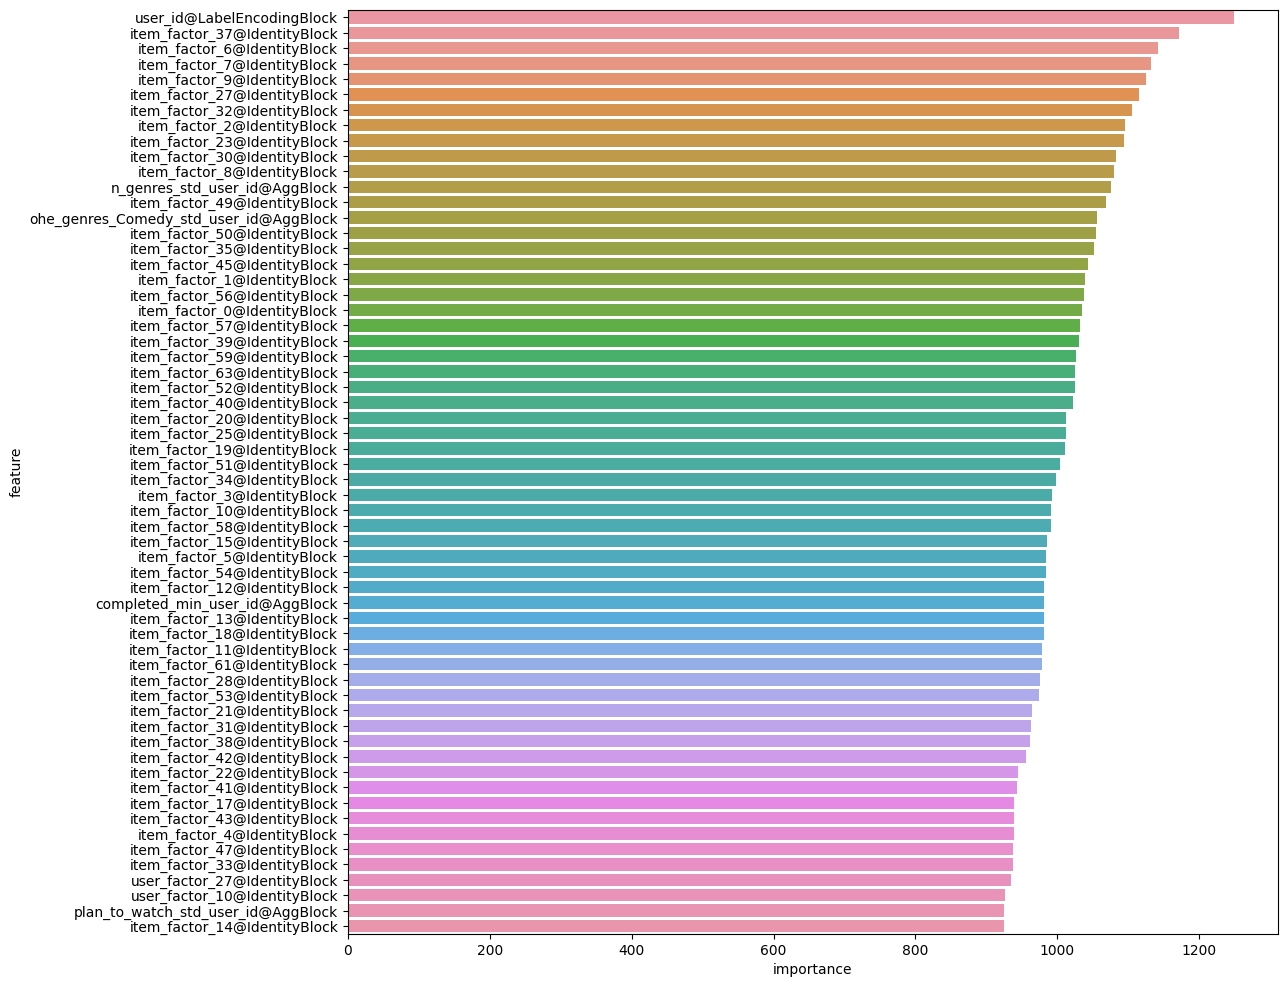

In [58]:
importance_df = pd.DataFrame()
for i_fold in range(cfg.n_splits):
    model = pickle.load(open(cfg.exp_model_path / f"seen_model_fold{i_fold}.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = i_fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False).head(60))

<Axes: xlabel='importance', ylabel='feature'>

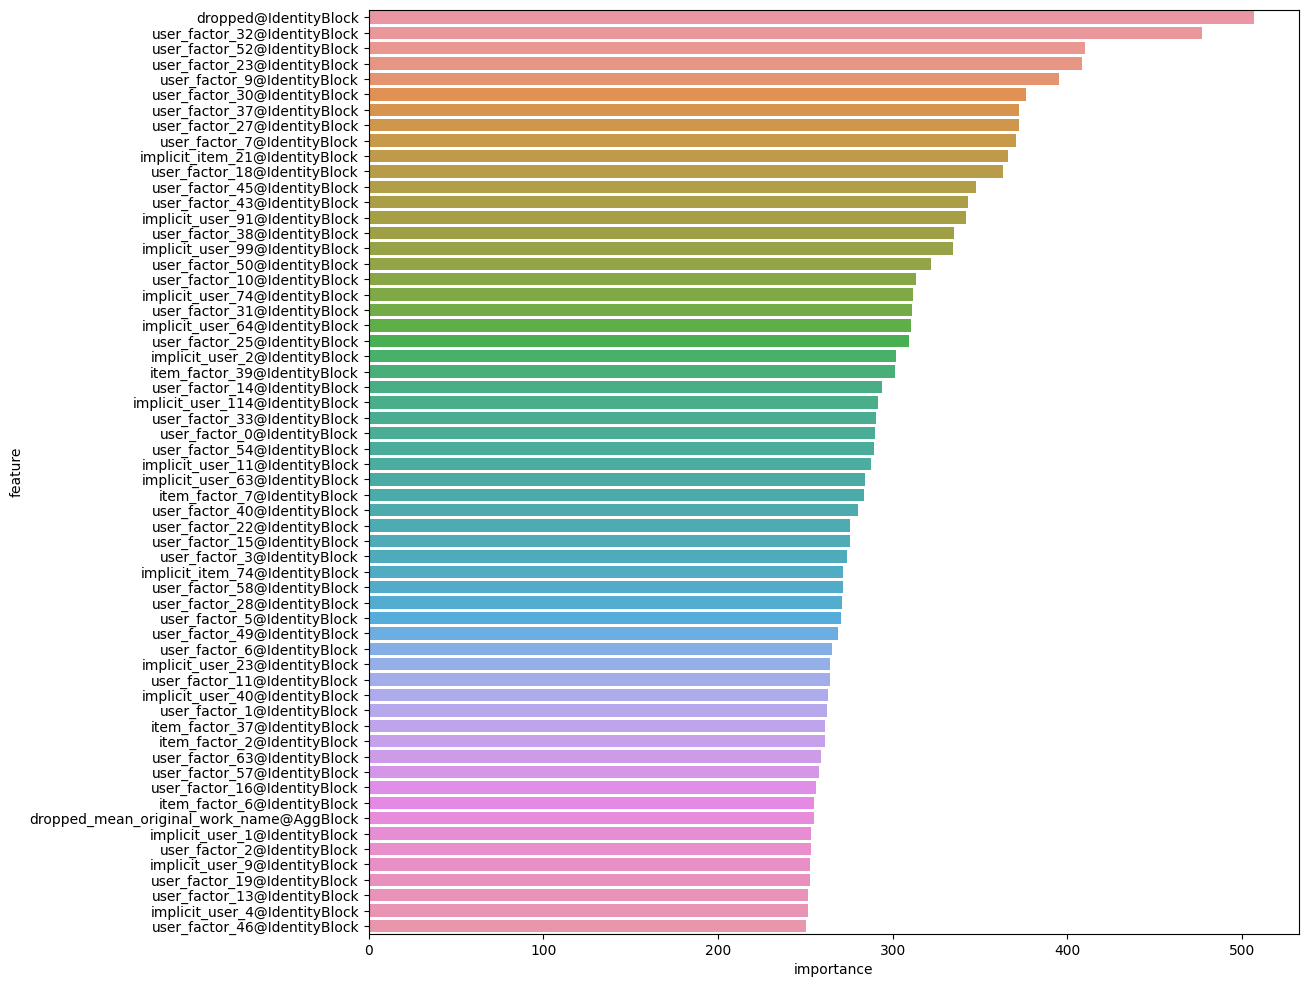

In [59]:
importance_df = pd.DataFrame()
for i_fold in range(cfg.n_splits):
    model = pickle.load(open(cfg.exp_model_path / f"unseen_model_fold{i_fold}.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = i_fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False).head(60))

Text(0.5, 1.0, 'All users')

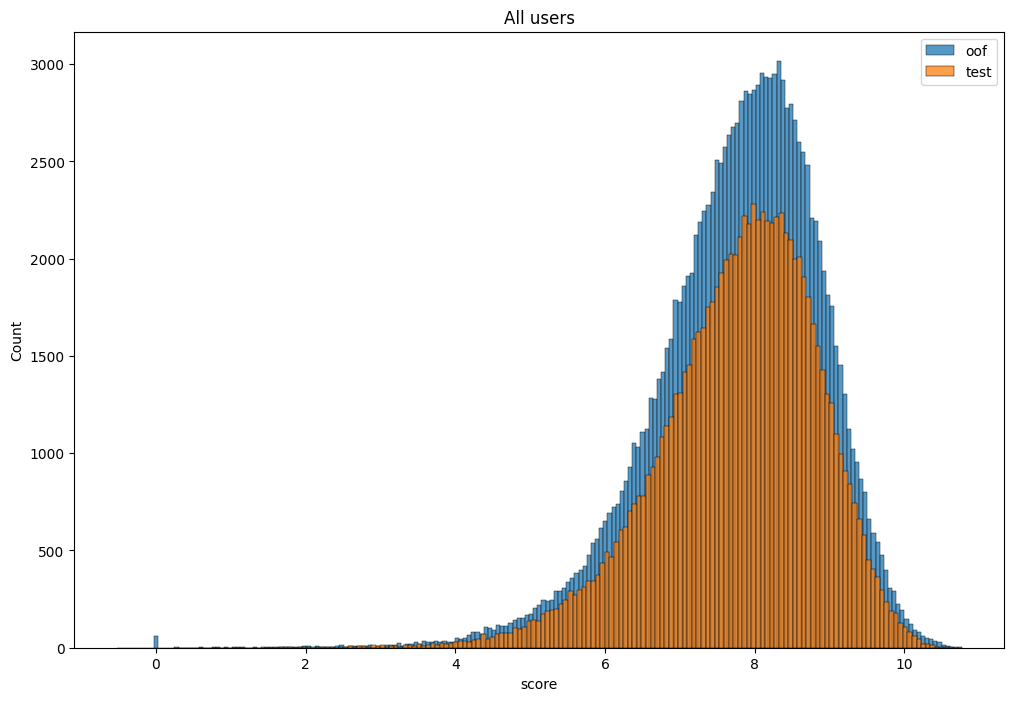

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=seen_oof, label="oof")
# sns.histplot(data=train_df["score"], label="target")
sns.histplot(data=test_df.iloc[seen_test_idx]["score"], label="test")
ax.legend()
ax.set_title("All users")

Text(0.5, 1.0, 'All users')

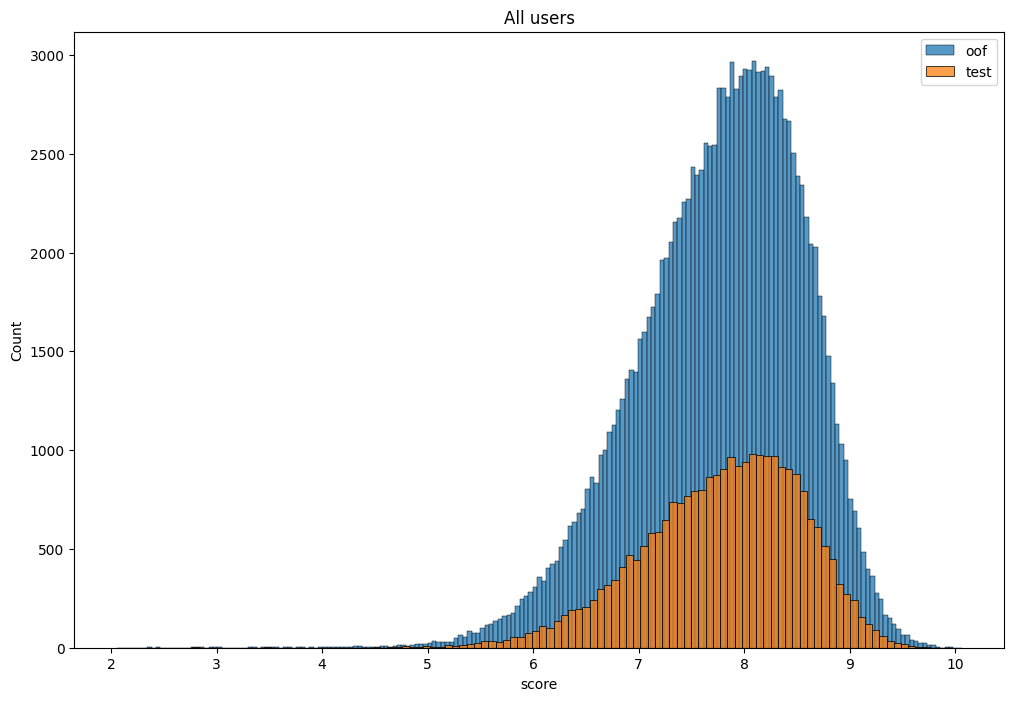

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=unseen_oof, label="oof")
# sns.histplot(data=train_df["score"], label="target")
sns.histplot(data=test_df.iloc[unseen_test_idx]["score"], label="test")
ax.legend()
ax.set_title("All users")